In [1]:
import keras.utils
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Import data

In [2]:
variable = {'phF': 0, 'MF': 1}['phF'] # TODO: for now just classify one variable

In [3]:
path = './Output'

In [4]:
# dimensions
N, HEIGHT, WIDTH, CHANNELS = sum([1 for p in os.listdir(path) if p[:14] == 'feature_vector']), \
                             *np.load(path + '/feature_vector0.npy').shape

# metadata (subjectID etc.)
with open(path + '/metadata.txt') as f:
    metadata = f.read()
metadata = json.loads(metadata.replace('\'', '\"').replace('False', 'false').replace('True', 'true')) # doesn't accept other chars

# Train/validation split

In [5]:
VALIDATION_SIZE = 0.2

In [6]:
# use unaugmented data for validation set
non_augmented = [i for i, meta in enumerate(metadata) if meta['augmented'] == False]

validation_indices = np.random.choice(non_augmented, int(N * VALIDATION_SIZE), replace=False)
training_indices = np.delete(np.arange(N), validation_indices)

In [7]:
print(f'Training set: {len(training_indices)}')
print(f'Validation set: {len(validation_indices)}')

Training set: 2478
Validation set: 619


# Define data generator

In [8]:
class DataGenerator(Sequence):

    def __init__(self, data_path: str, indices_dataset: list, batch_size=32, dim=(HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):
        self.data_path = data_path # path to full dataset
        self.dim = dim # image dimension
        self.batch_size = batch_size
        self.indices_dataset = indices_dataset # indices of full dataset (different for train/validation/test set)
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end() # shuffle data for each epoch

    def on_epoch_end(self):
        """
        Shuffle data for each epoch
        """
        if self.shuffle:
            np.random.shuffle(self.indices_dataset)

    def __data_generation(self, indices):
        """
        Loads and returns datapoints[indices]
        """
        # init
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty(self.batch_size, dtype=float) # TODO: int for non-logits

        # load individual datapoints
        for i, index in enumerate(indices):
            X[i, ] = np.load(self.data_path + f'/feature_vector{index}.npy', allow_pickle=True)
            y[i] = np.load(self.data_path + f'/labels{index}.npy', allow_pickle=True)[variable] # TODO: for now just one variable

        return X, y

    def __len__(self):
        """
        Number of batches per epoch
        """
        return int(np.floor(len(self.indices_dataset) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates batch[index]
        """
        # calculate indices of batch
        indices = self.indices_dataset[index * self.batch_size:(index + 1) * self.batch_size]

        # generate batch
        X, y = self.__data_generation(indices)

        return X, y

# Upsampling

In [9]:
UPSAMPLING_STRATEGY = 'nothing' # ['repeat', 'nothing']

In [10]:
def check_imbalance(path_to_labels, indices):
    """Returns indices of positives/negatives"""
    y = np.empty((len(indices), 2), dtype=int)
    for i, index in enumerate(indices):
        y[i, ] = np.load(path_to_labels + f'/labels{index}.npy', allow_pickle=True)

    positives = np.where(y[:, variable] == 1)[0] # TODO: for now just one variable
    negatives = np.where(y[:, variable] == 0)[0] # TODO: for now just one variable

    return np.array(indices)[positives], np.array(indices)[negatives]


# validation set
positives, negatives = check_imbalance(path, validation_indices)
print(f'validation: (+: {len(positives)}, -: {len(negatives)})')

# training set
positives, negatives = check_imbalance(path, training_indices)
print(f'train_set: (+: {len(positives)}, -: {len(negatives)})')

sample_weight = len(negatives) / len(positives) # for weighted cross-entropy

# upsampling training set
if UPSAMPLING_STRATEGY == 'repeat':
    upsampled_indices = np.random.choice(negatives, size=(len(positives) - len(negatives)), replace=True) # with replacement
    upsampled_indices = np.append(upsampled_indices, np.arange(N))
    training_indices = np.append(positives, negatives) # update

    positives, negatives = check_imbalance(path, upsampled_indices)
    print(f'train_set (upsampled): (+: {len(positives)}, -: {len(negatives)})')
if UPSAMPLING_STRATEGY == 'nothing':
    pass

print(f'\nWeighted loss function: weight = {sample_weight}')

validation: (+: 467, -: 152)
train_set: (+: 1825, -: 653)

Weighted loss function: weight = 0.3578082191780822


# CNN

Data generators

In [11]:
training_batch_generator = DataGenerator(data_path=path, indices_dataset=training_indices, batch_size=128)
validation_batch_generator = DataGenerator(data_path=path, indices_dataset=validation_indices, batch_size=32) # TODO: use test set to avoid mixing

Model

In [12]:
# wrapper functions
def weighted_cross_entropy(weight):
    def weighted_cross_entropy_with_logits(labels, logits):
        loss = tf.nn.weighted_cross_entropy_with_logits(
            labels, logits, weight
        )
        return loss
    return weighted_cross_entropy_with_logits

class accuracy_with_logits(tf.keras.metrics.Accuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        return super(accuracy_with_logits, self).update_state(y_true, y_pred, sample_weight)

class recall_with_logits(tf.keras.metrics.Recall):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        return super(recall_with_logits, self).update_state(y_true, y_pred, sample_weight)

class precision_with_logits(tf.keras.metrics.Precision):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        return super(precision_with_logits, self).update_state(y_true, y_pred, sample_weight)

In [13]:
model = models.Sequential(name='custom_CNN')

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(370, 100, 30), padding='same', name='conv1-1'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv1-2'))
model.add(BatchNormalization(name='batch_norm1')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool1'))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv2-1'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv2-2'))
model.add(BatchNormalization(name='batch_norm2')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool2'))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv3-1'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv3-2'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv3-3'))
model.add(BatchNormalization(name='batch_norm3')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool3'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv4-1'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv4-2'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv4-3'))
model.add(BatchNormalization(name='batch_norm4')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool4'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv5-1'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv5-2'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv5-3'))
model.add(BatchNormalization(name='batch_norm5')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool5'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv6-1'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv6-2'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv6-3'))
model.add(BatchNormalization(name='batch_norm6')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool6'))

model.add(Flatten(name='flatten'))
model.add(Dense(128, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer='l2', name='dense1'))
model.add(Dropout(0.4, name='dropout1')) # TODO: worth it? parameter scale adequate?
model.add(Dense(64, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer='l2', name='dense2'))
model.add(Dropout(0.3, name='dropout2')) # TODO: worth it? parameter scale adequate?
model.add(Dense(1, kernel_regularizer='l2', name='dense3'))

#model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
model.compile(optimizer=Adam(learning_rate=1e-5), loss=weighted_cross_entropy(sample_weight), metrics=[accuracy_with_logits(),
                                                                                              recall_with_logits(),
                                                                                              precision_with_logits()])

model.summary()

Model: "custom_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1-1 (Conv2D)             (None, 370, 100, 16)      4336      
_________________________________________________________________
conv1-2 (Conv2D)             (None, 370, 100, 16)      2320      
_________________________________________________________________
batch_norm1 (BatchNormalizat (None, 370, 100, 16)      64        
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 185, 50, 16)       0         
_________________________________________________________________
conv2-1 (Conv2D)             (None, 185, 50, 16)       2320      
_________________________________________________________________
conv2-2 (Conv2D)             (None, 185, 50, 16)       2320      
_________________________________________________________________
batch_norm2 (BatchNormalizat (None, 185, 50, 16)       6

Training

In [14]:
%%time
# save best performing model
checkpoint_path = './temp/checkpoint_model'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            save_best_only=True)

# train
history = model.fit_generator(generator=training_batch_generator,
                              validation_data=validation_batch_generator,
                              epochs=10,
                              callbacks=[model_checkpoint_callback])

C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
19/19 [==============================] - 49s 2s/step - loss: 1.1216 - accuracy: 0.4618 - recall_with_logits: 0.3999 - precision_with_logits: 0.7547 - val_loss: 1.1016 - val_accuracy: 0.2451 - val_recall_with_logits: 0.0000e+00 - val_precision_with_logits: 0.0000e+00
Epoch 2/10
19/19 [==============================] - 20s 1s/step - loss: 1.1169 - accuracy: 0.4700 - recall_with_logits: 0.4234 - precision_with_logits: 0.7458 - val_loss: 1.0984 - val_accuracy: 0.2434 - val_recall_with_logits: 0.0000e+00 - val_precision_with_logits: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 19s 1s/step - loss: 1.1139 - accuracy: 0.4753 - recall_with_logits: 0.4262 - precision_with_logits: 0.7530 - val_loss: 1.0967 - val_accuracy: 0.2451 - val_recall_with_logits: 0.0000e+00 - val_precision_with_logits: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 19s 1s/step - loss: 1.1096 - accuracy: 0.4901 - recall_with_logits: 0.4566 - precision_with_logits: 0.7574 - val_l

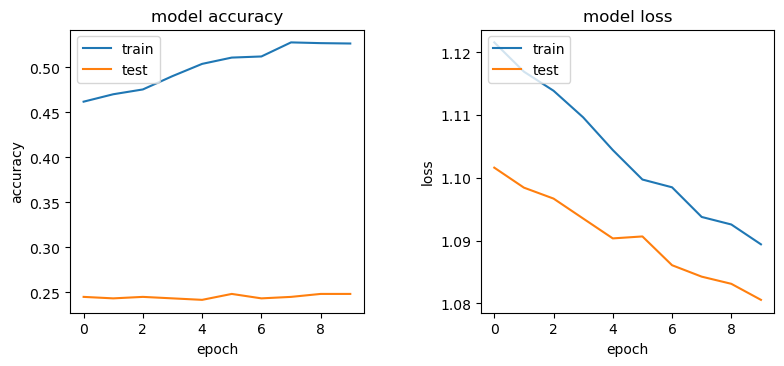

In [15]:
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

# metric
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

# Evaluation

In [16]:
# load best performing model
model.load_weights(checkpoint_path)

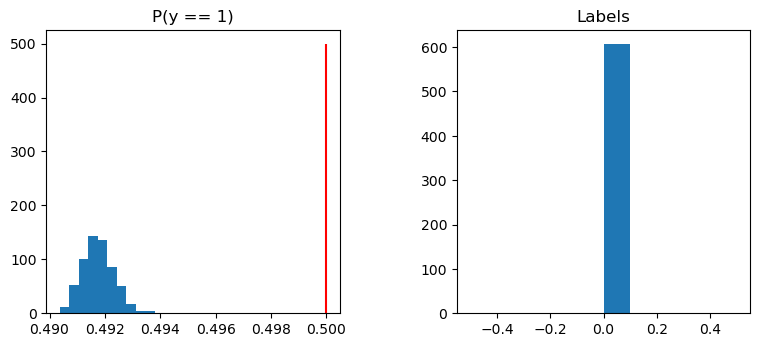

In [17]:
# predict on validation set
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

y_pred = model.predict(validation_batch_generator)
y_pred = tf.math.sigmoid(y_pred).numpy() # TODO: for logits

# for probs
plt.subplot(1, 2, 1)
plt.hist(y_pred.reshape(-1))
plt.title('P(y == 1)')
plt.vlines(x=0.5, ymin=0, ymax=500, color='red')

y_pred = np.where(y_pred > 0.5, 1, 0) # as labels
plt.subplot(1, 2, 2)
plt.hist(y_pred.reshape(-1))
plt.title('Labels')

plt.show()

In [18]:
# load test data
print(f'Test set: {len(validation_indices)}') # TODO: separate test-set

test_batch_generator = DataGenerator(data_path=path, indices_dataset=validation_indices, batch_size=1) # TODO: separate test-set
y_test = np.empty(0)
for batch_index in range(len(test_batch_generator)):
    _, y_test_batch = test_batch_generator.__getitem__(batch_index)
    y_test = np.append(y_test, y_test_batch)

Test set: 619


accuracy: 0.2455573505654281
balanced accuracy: 0.5
f1 (weighted): 0.09682157532022068
recall (weighted): 0.2455573505654281
precision (weighted): 0.06029841241671255


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


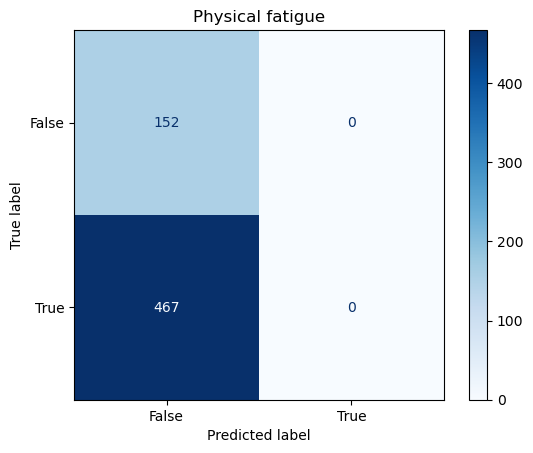

In [19]:
# classification metrics
# predict
y_test_pred = model.predict(test_batch_generator)
y_test_pred = tf.math.sigmoid(y_test_pred).numpy() # TODO: for logits
y_test_pred = np.round(y_test_pred)

# evaluate
accuracy = accuracy_score(y_pred=y_test_pred, y_true=y_test)
balanced_accuracy = balanced_accuracy_score(y_pred=y_test_pred, y_true=y_test)
f1_weighted = f1_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
recall_weighted = recall_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
precision_weighted = precision_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
confusion = confusion_matrix(y_pred=y_test_pred, y_true=y_test)
ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
plt.title('Physical fatigue')

print(f'accuracy: {accuracy}\n'
      f'balanced accuracy: {balanced_accuracy}\n'
      f'f1 (weighted): {f1_weighted}\n'
      f'recall (weighted): {recall_weighted}\n'
      f'precision (weighted): {precision_weighted}')

# Continue training

In [20]:
%%time
# save best performing model
checkpoint_path = './temp/checkpoint_model2'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            save_best_only=True)

# train
history2 = model.fit_generator(generator=training_batch_generator,
                              validation_data=validation_batch_generator,
                              epochs=20,
                              callbacks=[model_checkpoint_callback])

C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
19/19 [==============================] - 20s 1s/step - loss: 1.0881 - accuracy: 0.5173 - recall_with_logits: 0.4986 - precision_with_logits: 0.7622 - val_loss: 1.0766 - val_accuracy: 0.2451 - val_recall_with_logits: 0.0000e+00 - val_precision_with_logits: 0.0000e+00
Epoch 2/20
19/19 [==============================] - 19s 1s/step - loss: 1.0852 - accuracy: 0.5156 - recall_with_logits: 0.5075 - precision_with_logits: 0.7560 - val_loss: 1.0727 - val_accuracy: 0.2418 - val_recall_with_logits: 0.0000e+00 - val_precision_with_logits: 0.0000e+00
Epoch 3/20
19/19 [==============================] - 19s 1s/step - loss: 1.0816 - accuracy: 0.5206 - recall_with_logits: 0.5053 - precision_with_logits: 0.7620 - val_loss: 1.0716 - val_accuracy: 0.2451 - val_recall_with_logits: 0.0000e+00 - val_precision_with_logits: 0.0000e+00
Epoch 4/20
19/19 [==============================] - 19s 1s/step - loss: 1.0813 - accuracy: 0.5033 - recall_with_logits: 0.4925 - precision_with_logits: 0.7477 - val_l

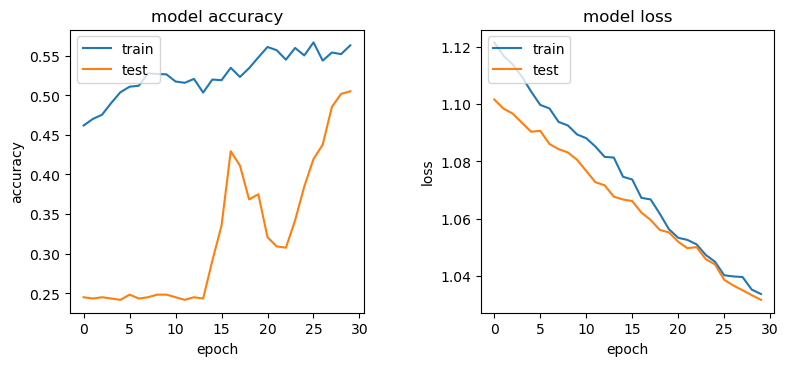

In [21]:
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

full_history_acc = history.history['accuracy'] + history2.history['accuracy']
full_history_val_acc = history.history['val_accuracy'] + history2.history['val_accuracy']
full_history_loss = history.history['loss'] + history2.history['loss']
full_history_val_loss = history.history['val_loss'] + history2.history['val_loss']

# metric
plt.subplot(1, 2, 1)
plt.plot(full_history_acc)
plt.plot(full_history_val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# loss
plt.subplot(1, 2, 2)
plt.plot(full_history_loss)
plt.plot(full_history_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [22]:
%%time
# save best performing model
checkpoint_path = './temp/checkpoint_model3'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            save_best_only=True)

# train
history3 = model.fit_generator(generator=training_batch_generator,
                               validation_data=validation_batch_generator,
                               epochs=20,
                               callbacks=[model_checkpoint_callback])

Epoch 1/20
19/19 [==============================] - 21s 1s/step - loss: 1.0277 - accuracy: 0.5641 - recall_with_logits: 0.5581 - precision_with_logits: 0.7879 - val_loss: 1.0270 - val_accuracy: 0.5148 - val_recall_with_logits: 0.5142 - val_precision_with_logits: 0.7662
Epoch 2/20
19/19 [==============================] - 21s 1s/step - loss: 1.0262 - accuracy: 0.5477 - recall_with_logits: 0.5313 - precision_with_logits: 0.7838 - val_loss: 1.0252 - val_accuracy: 0.5247 - val_recall_with_logits: 0.5339 - val_precision_with_logits: 0.7625
Epoch 3/20
19/19 [==============================] - 22s 1s/step - loss: 1.0281 - accuracy: 0.5567 - recall_with_logits: 0.5511 - precision_with_logits: 0.7819 - val_loss: 1.0229 - val_accuracy: 0.5461 - val_recall_with_logits: 0.5667 - val_precision_with_logits: 0.7685
Epoch 4/20
19/19 [==============================] - 20s 1s/step - loss: 1.0186 - accuracy: 0.5621 - recall_with_logits: 0.5367 - precision_with_logits: 0.8018 - val_loss: 1.0199 - val_accura

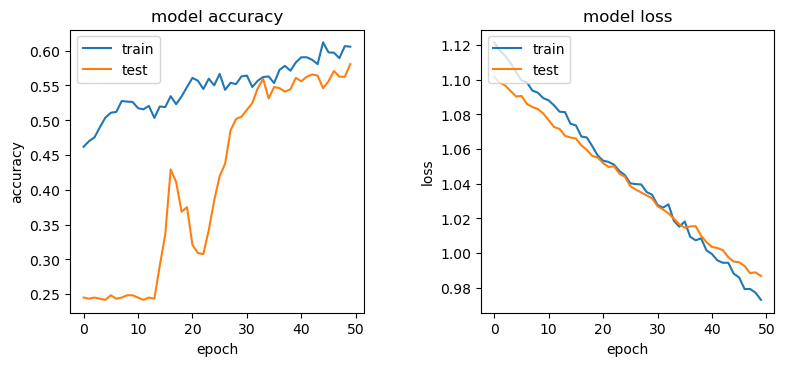

In [23]:
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

full_history_acc = history.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy']
full_history_val_acc = history.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy']
full_history_loss = history.history['loss'] + history2.history['loss'] + history3.history['loss']
full_history_val_loss = history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss']

# metric
plt.subplot(1, 2, 1)
plt.plot(full_history_acc)
plt.plot(full_history_val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# loss
plt.subplot(1, 2, 2)
plt.plot(full_history_loss)
plt.plot(full_history_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [24]:
%%time
# save best performing model
checkpoint_path = './temp/checkpoint_model4'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            save_best_only=True)

# train
history4 = model.fit_generator(generator=training_batch_generator,
                               validation_data=validation_batch_generator,
                               epochs=50,
                               callbacks=[model_checkpoint_callback])

Epoch 1/50
19/19 [==============================] - 22s 1s/step - loss: 0.9707 - accuracy: 0.6020 - recall_with_logits: 0.5913 - precision_with_logits: 0.8161 - val_loss: 0.9821 - val_accuracy: 0.5707 - val_recall_with_logits: 0.6253 - val_precision_with_logits: 0.7633
Epoch 2/50
19/19 [==============================] - 21s 1s/step - loss: 0.9684 - accuracy: 0.6024 - recall_with_logits: 0.5875 - precision_with_logits: 0.8211 - val_loss: 0.9802 - val_accuracy: 0.5806 - val_recall_with_logits: 0.6258 - val_precision_with_logits: 0.7730
Epoch 3/50
19/19 [==============================] - 20s 1s/step - loss: 0.9649 - accuracy: 0.6073 - recall_with_logits: 0.6009 - precision_with_logits: 0.8185 - val_loss: 0.9773 - val_accuracy: 0.5724 - val_recall_with_logits: 0.6214 - val_precision_with_logits: 0.7655
Epoch 4/50
19/19 [==============================] - 20s 1s/step - loss: 0.9618 - accuracy: 0.6188 - recall_with_logits: 0.6036 - precision_with_logits: 0.8328 - val_loss: 0.9769 - val_accura

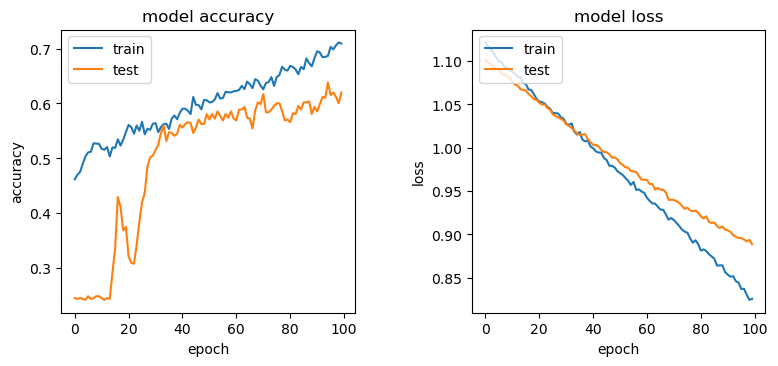

In [25]:
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

full_history_acc = history.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy'] + history4.history['accuracy']
full_history_val_acc = history.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy'] + history4.history['val_accuracy']
full_history_loss = history.history['loss'] + history2.history['loss'] + history3.history['loss'] + history4.history['loss']
full_history_val_loss = history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'] + history4.history['val_loss']

# metric
plt.subplot(1, 2, 1)
plt.plot(full_history_acc)
plt.plot(full_history_val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# loss
plt.subplot(1, 2, 2)
plt.plot(full_history_loss)
plt.plot(full_history_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [26]:
%%time
# save best performing model
checkpoint_path = './temp/checkpoint_model5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            save_best_only=True)

# train
history5 = model.fit_generator(generator=training_batch_generator,
                               validation_data=validation_batch_generator,
                               epochs=50,
                               callbacks=[model_checkpoint_callback])

Epoch 1/50
19/19 [==============================] - 22s 1s/step - loss: 0.8158 - accuracy: 0.7134 - recall_with_logits: 0.6935 - precision_with_logits: 0.8952 - val_loss: 0.8831 - val_accuracy: 0.6020 - val_recall_with_logits: 0.6638 - val_precision_with_logits: 0.7786
Epoch 2/50
19/19 [==============================] - 22s 1s/step - loss: 0.8118 - accuracy: 0.7245 - recall_with_logits: 0.7158 - precision_with_logits: 0.8884 - val_loss: 0.8914 - val_accuracy: 0.6086 - val_recall_with_logits: 0.6718 - val_precision_with_logits: 0.7772
Epoch 3/50
19/19 [==============================] - 22s 1s/step - loss: 0.8167 - accuracy: 0.7200 - recall_with_logits: 0.7145 - precision_with_logits: 0.8843 - val_loss: 0.8828 - val_accuracy: 0.6217 - val_recall_with_logits: 0.6848 - val_precision_with_logits: 0.7875
Epoch 4/50
19/19 [==============================] - 21s 1s/step - loss: 0.8109 - accuracy: 0.7266 - recall_with_logits: 0.7156 - precision_with_logits: 0.8922 - val_loss: 0.8875 - val_accura

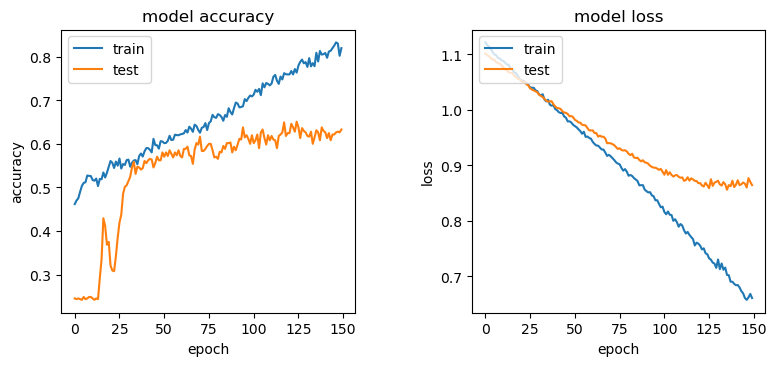

In [27]:
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

full_history_acc = history.history['accuracy'] + history2.history['accuracy'] + \
                   history3.history['accuracy'] + history4.history['accuracy']+ history5.history['accuracy']
full_history_val_acc = history.history['val_accuracy'] + history2.history['val_accuracy'] + \
                       history3.history['val_accuracy'] + history4.history['val_accuracy']+ history5.history['val_accuracy']
full_history_loss = history.history['loss'] + history2.history['loss'] + history3.history['loss'] + \
                    history4.history['loss'] + history5.history['loss']
full_history_val_loss = history.history['val_loss'] + history2.history['val_loss'] + \
                        history3.history['val_loss'] + history4.history['val_loss'] + history5.history['val_loss']

# metric
plt.subplot(1, 2, 1)
plt.plot(full_history_acc)
plt.plot(full_history_val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# loss
plt.subplot(1, 2, 2)
plt.plot(full_history_loss)
plt.plot(full_history_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:
# load best performing model
'''model.load_weights(checkpoint_path)'''

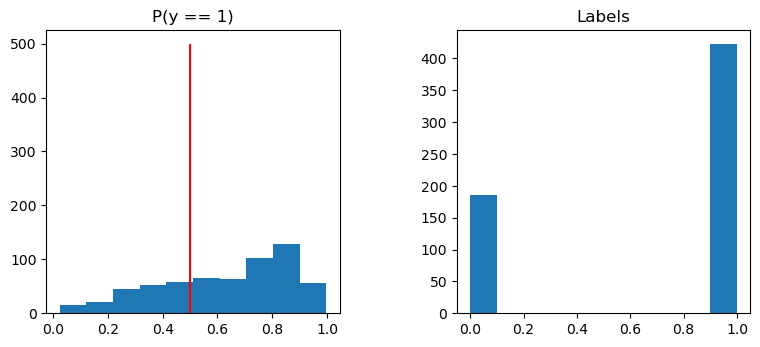

In [28]:
# predict on validation set
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

y_pred = model.predict(validation_batch_generator)
y_pred = tf.math.sigmoid(y_pred).numpy() # TODO: for logits

# for probs
plt.subplot(1, 2, 1)
plt.hist(y_pred.reshape(-1))
plt.title('P(y == 1)')
plt.vlines(x=0.5, ymin=0, ymax=500, color='red')

y_pred = np.where(y_pred > 0.5, 1, 0) # as labels
plt.subplot(1, 2, 2)
plt.hist(y_pred.reshape(-1))
plt.title('Labels')

plt.show()

In [29]:
# load test data
print(f'Test set: {len(validation_indices)}') # TODO: separate test-set

test_batch_generator = DataGenerator(data_path=path, indices_dataset=validation_indices, batch_size=1) # TODO: separate test-set
y_test = np.empty(0)
for batch_index in range(len(test_batch_generator)):
    _, y_test_batch = test_batch_generator.__getitem__(batch_index)
    y_test = np.append(y_test, y_test_batch)

Test set: 619


accuracy: 0.6348949919224556
balanced accuracy: 0.5494618505578722
f1 (weighted): 0.6474364213913891
recall (weighted): 0.6348949919224556
precision (weighted): 0.6640931497151206


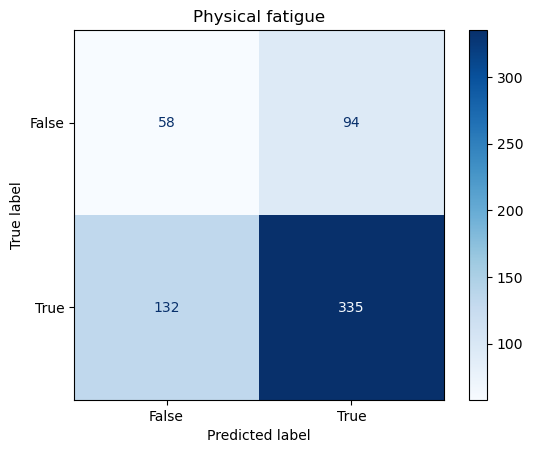

In [30]:
# classification metrics
# predict
y_test_pred = model.predict(test_batch_generator)
y_test_pred = tf.math.sigmoid(y_test_pred).numpy() # TODO: for logits
y_test_pred = np.round(y_test_pred)

# evaluate
accuracy = accuracy_score(y_pred=y_test_pred, y_true=y_test)
balanced_accuracy = balanced_accuracy_score(y_pred=y_test_pred, y_true=y_test)
f1_weighted = f1_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
recall_weighted = recall_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
precision_weighted = precision_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
confusion = confusion_matrix(y_pred=y_test_pred, y_true=y_test)
ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
plt.title('Physical fatigue')

print(f'accuracy: {accuracy}\n'
      f'balanced accuracy: {balanced_accuracy}\n'
      f'f1 (weighted): {f1_weighted}\n'
      f'recall (weighted): {recall_weighted}\n'
      f'precision (weighted): {precision_weighted}')

In [42]:
# save history
with open('./temp/full_history_acc','w') as dat:
    dat.write(str(full_history_acc))

with open('./temp/full_history_val_acc','w') as dat:
    dat.write(str(full_history_val_acc))

with open('./temp/full_history_loss','w') as dat:
    dat.write(str(full_history_loss))

with open('./temp/full_history_val_loss','w') as dat:
    dat.write(str(full_history_val_loss))

In [43]:
# save model
model.save('./temp/CNN_full_history')

INFO:tensorflow:Assets written to: ./temp/CNN_full_history\assets


INFO:tensorflow:Assets written to: ./temp/CNN_full_history\assets
